# Exercise 3 (Clustering)

Πουλος Βασίλης: 2805  
Κωστάκης Ελευθέριος-Παναγιώτης: 2741

## Loading data

In [4]:
import pandas as pd
import numpy as np
import json
import time 

dataset_path = '../yelp-dataset/' # Change this path to match your local dataset folder path
leftK_path = '/home/left/Desktop/dataMining/set2/ask2/'
#dataset_path = leftK_path

business_filename = 'yelp_academic_dataset_business.json'
review_filename = 'yelp_academic_dataset_review.json'

# Reading business file
start = time.time()

list_business = []
categories_order = ['Beauty & Spas', 'Shopping', 'Bars']

with open(dataset_path + business_filename, 'r', encoding="utf8") as buisness_file:
    for line in buisness_file:
        json_dict = json.loads(line)
        if  json_dict['city'] == 'Toronto' and \
            json_dict['review_count'] >= 10 and \
            json_dict['categories'] is not None: # and \
            #any(word in json_dict['categories'] for word in categories_order):
                cat = [x.strip(" ") for x in json_dict['categories'].split(",")]
                if "Beauty & Spas" in cat:
                    temp_cat = "Beauty & Spas"
                    list_business.append([json_dict['business_id'], temp_cat])
                elif "Shopping" in cat:
                    temp_cat = "Shopping"
                    list_business.append([json_dict['business_id'], temp_cat])
                elif "Bars" in cat:
                    temp_cat = "Bars"
                    list_business.append([json_dict['business_id'], temp_cat]) 
                # The following line makes sure that every buisness categoy is
                # set to one of the categories_order list in that specific order.
                # temp_cat = [cat for cat in categories_order if cat in json_dict['categories']][0]
                # list_business.append([json_dict['business_id'], temp_cat])

stop = time.time()
print("Read file in {:.3f} seconds".format(stop-start))

df_buisness = pd.DataFrame(list_business, columns=['business_id', 'categories'])
display(df_buisness.head())
print('{} businesses in df_buisness'.format(df_buisness['business_id'].size))

Read file in 2.229 seconds


,business_id,categories
0,cicPsia8Wj-DNRkmLbD_xg,Bars
1,xVXyrTWbG8U3szze-aA7eg,Bars
2,e-tRKAC-q40SqQfAOwYa-A,Beauty & Spas
3,C9keC4mWuXdl2mYFHZXudQ,Shopping
4,PFS9kf3U-ZCvpqay3AaNnQ,Shopping


2991 businesses in df_buisness


In [5]:
# Extracting unique buisness ids
np_businesses = np.array(list_business)
np_businesses_ids = np_businesses[:,0]
np_businesses_ids

array(['cicPsia8Wj-DNRkmLbD_xg', 'xVXyrTWbG8U3szze-aA7eg',
       'e-tRKAC-q40SqQfAOwYa-A', ..., 'wjqOdj0XJUDOOtU9LjRlWQ',
       'AqpB2IoLkUupDCuH-hmVdg', '0hudPyuCBlKg79OwKBw-eQ'], dtype='<U22')

In [6]:
def find_buisness_index(business_id):
    index = np.where(np_businesses_ids == business_id)[0]
    return index

# Reading reveiws file
start = time.time()
business_reviews = [[] for i in range(int(len(np_businesses_ids)))]

with open(dataset_path + review_filename, 'r', encoding="utf8") as reviews_file:
    for line in reviews_file:
        json_dict = json.loads(line)
        index = find_buisness_index(json_dict['business_id'])
        if index.size > 0:
            if len(business_reviews[index[0]]) == 0:
               business_reviews[index[0]] = json_dict['text']
            else:
               business_reviews[index[0]] += json_dict['text']

stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 4.544 mins


Reading time: about 5 mins

In [7]:
df_business_reviews = pd.DataFrame(business_reviews, columns=['reviews as a single string for each buisness'])
df_business_reviews

,reviews as a single string for each buisness
0,"Consistently good, as the Keg tends to be.\n\n..."
1,I would give zero stars. I came here with a gr...
2,A blissful experience! I highly recommended th...
3,If you're a boy and you want to wear some hot ...
4,"As a country girl, I often find myself missing..."
...,...
2986,Good tacos in the downtown core are hard to co...
2987,This used to be my favourite place. It was alw...
2988,Very welcoming place. Great setup and super fr...
2989,I can't beleive I am saying this... but I left...


## TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Load custom stopwords 
# source: https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt
with open('stopwords.txt', 'r') as text_file:
    lines = text_file.read().split('\n')

stop_words = text.ENGLISH_STOP_WORDS.union(lines)

# Allowing words that are alpharithmetics more than 2 chars, excluding
# common words that exist in more than max_df of docs and rare words that
# exist in less than min_df of docs.
tfidf = TfidfVectorizer(min_df=0.25,
                        max_df=0.85,
                        max_features=8000,
                        token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b',
                        lowercase=True,
                        stop_words=stop_words)

document_term_matrix = tfidf.fit_transform(business_reviews)

In [9]:
import random 
samples_num = 30
print('Sample of words included in the features:\n{}\n\n'.format(random.sample(tfidf.get_feature_names(), samples_num)))
print('Sample of effective stop words list.:\n{}'.format(random.sample(tfidf.get_stop_words(), samples_num)))

Sample of words included in the features:
['ambience', 'check', 'hit', 'cost', 'months', 'area', 'lovely', 'bite', 'easy', 'prefer', 'husband', 'queen', 'far', 'realized', 'black', 'questions', 'expected', 'stick', 'town', 'places', 'perfect', 'wanted', 'atmosphere', 'canada', 'taking', 'missing', 'incredibly', 'deep', 'employees', 'start']


Sample of effective stop words list.:
['umpteen', 'alongside', 'shall', 'yond', 'sometime', 'con', 'most', 'whichsoever', 'nighest', 'anyone', 'fill', 'either', 'ases', 'us', 'without', 'therer', 'inc', 'sines', 'beside', 'natheless', 'k', 'dost', 'neither', 'when', 'whereof', 'no', 'she', 'sine', 'provided', 'figuponing']


## Kmeans and Agglomerative Clustering

In [10]:
from sklearn.cluster import KMeans
import sklearn.cluster as sk_cluster
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-paper')

# True values table: Μatching categories to numbers
true_labels = np_businesses[:,1]
for i in range(len(true_labels)):
    if true_labels[i]=='Bars':
        true_labels[i]=0
    if true_labels[i]=='Beauty & Spas':
        true_labels[i]=1
    if true_labels[i]=='Shopping':
        true_labels[i]=2
    
true_labels = [int(i) for i in true_labels] 

def disp_cluster_values(data, labels):
    df = pd.DataFrame(data.todense(), columns=tfidf.get_feature_names())
    df['category'] = labels
    new_df = df.groupby(['category']).mean()
    cluster0 = new_df.iloc[0]
    cluster1 = new_df.iloc[1]
    cluster2 = new_df.iloc[2]
    display(cluster0.sort_values(ascending=False).head(10))
    display(cluster1.sort_values(ascending=False).head(10))
    display(cluster2.sort_values(ascending=False).head(10))

def Kmeans_winfo(n_clusters, true_labels, data):
    kmeans = KMeans(init='k-means++', 
                    n_clusters=n_clusters, 
                    n_init=25, 
                    max_iter=600,  
                    random_state=42)

    predictions = kmeans.fit_predict(data)
    error = kmeans.inertia_
    cfm = confusion_matrix(true_labels, predictions) 

    # Mapping kmeans labels 
    mapping = list(np.argmax(cfm, axis=0))
    mapped_kmeans_labels = [0 for i in range(len(predictions))]
    for i in range(len(predictions)):
        mapped_kmeans_labels[i] = mapping[predictions[i]]

    score = silhouette_score(data, mapped_kmeans_labels)
    mapped_cfm = confusion_matrix(true_labels, mapped_kmeans_labels)
    precision = precision_score(true_labels, mapped_kmeans_labels, average=None)
    weighted_precision = precision_score(true_labels, mapped_kmeans_labels, average='weighted')
    recall = recall_score(true_labels, mapped_kmeans_labels, average = None)
    weighted_recall = recall_score(true_labels,mapped_kmeans_labels, average = 'weighted')
    
    
    # Display info
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)

    # PCA 
    reduced_data = PCA(n_components=2).fit_transform(data.todense())
    centers_2d = PCA(n_components=2).fit_transform(kmeans.cluster_centers_)
    
    plt.title('PCA Cluster Plot')
    plt.scatter(reduced_data[:,0], reduced_data[:,1], c=predictions ,s=50, cmap='viridis', alpha= 0.6)
    plt.scatter(centers_2d[:,0], centers_2d[:,1], 
                marker='o', s=200, c='black', alpha=0.5)

    axis_labels = ['Bars', 'Beauty & Spas', 'Shopping']
    plt.subplot(1, 3, 2)
    plt.title('Confusion Matrix')
    plt.axis('square')
    sns.heatmap(cfm, annot=True, cmap='Blues', cbar=False, fmt='d', xticklabels=axis_labels,
                yticklabels=axis_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 3, 3)
    plt.title('Mapped Confusion Matrix')
    plt.axis('square')
    sns.heatmap(mapped_cfm, annot=True, cmap='Blues', cbar=False, fmt='d', xticklabels=axis_labels,
                yticklabels=axis_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Precision : {}".format(precision))
    print("Weighted precision: {:.3f}".format(weighted_precision))
    print("Recall : {}".format(recall))
    print("Weighted recall: {:.3f}".format(weighted_precision))
    print("Score : {:.3f}".format(score))

    return mapped_kmeans_labels, predictions, centers_2d

In [11]:
def display_agglomerative_info(true_labels, predictions, data):
    cfm = confusion_matrix(true_labels, predictions) 

    mapping = list(np.argmax(cfm, axis=0))
    mapped_kmeans_labels = [0 for i in range(len(predictions))]
    for i in range(len(predictions)):
        mapped_kmeans_labels[i] = mapping[predictions[i]]

    score = silhouette_score(data, mapped_kmeans_labels)
    mapped_cfm = confusion_matrix(true_labels, mapped_kmeans_labels)
    precision = precision_score(true_labels, mapped_kmeans_labels, average=None)
    weighted_precision = precision_score(true_labels, mapped_kmeans_labels, average='weighted')
    recall = recall_score(true_labels, mapped_kmeans_labels, average = None)
    weighted_recall =recall_score(true_labels,mapped_kmeans_labels, average = 'weighted')
    
    # Display info
    plt.figure(figsize=(15, 5))
    x_axis_labels = ['Bars', 'Beauty & Spas', 'Shopping']
    plt.title('Mapped Confusion Matrix')
    plt.axis('square')
    sns.heatmap(mapped_cfm, annot=True, cmap='Blues', cbar=False, fmt='d', xticklabels=x_axis_labels,
                        yticklabels=x_axis_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Precision : {}".format(precision))
    print("Weighted precision: {:.3f}".format(weighted_precision))
    print("Recall : {}".format(recall))
    print("Weighted recall: {:.3f}".format(weighted_precision))
    print("Score : {:.3f}".format(score))

## Part 1

We answer part 3 of the question with the pca cluster plots at part 1 and part 2. 

### Kmeans

In [12]:
n0 = true_labels.count(0)
n1 = true_labels.count(1)
n2 = true_labels.count(2)
print('Bars: {}\nBeauty & Spas: {}\nShopping: {}\nSum: {}'.format(n0, n1, n2, n0+n1+n2))

Bars: 1258
Beauty & Spas: 826
Shopping: 907
Sum: 2991


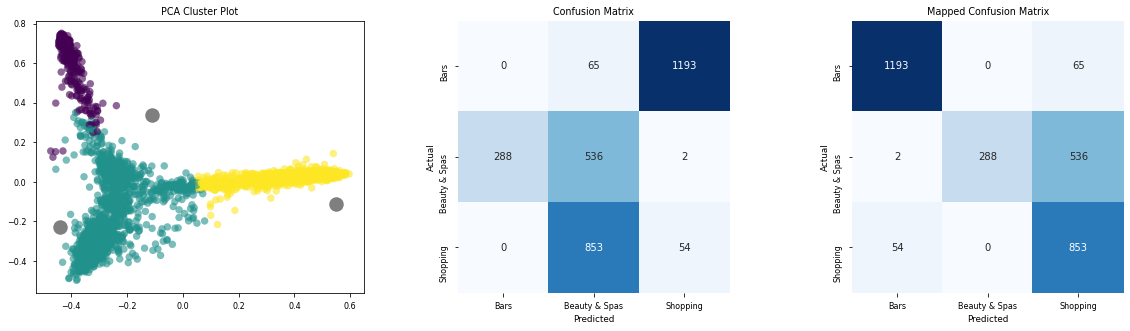

Precision : [0.95516413 1.         0.5866575 ]
Weighted precision: 0.856
Recall : [0.94833068 0.34866828 0.94046307]
Weighted recall: 0.856
Score : 0.161


In [13]:
labels_c3, pred_c3, centers_2d_c3 = Kmeans_winfo(3, true_labels, document_term_matrix)

Kmeans for 3 clusters returns good precision for the first two classifiers but lower for the third one
("Shopping"). As for the recall values per classifier, the recall for the first and last classifiers
is high but for "Beauty & Spas" is low. This indicates that the "Shopping" classifier labeled as 
possitive samples that were negative and the "Beauty & Spas" classifier was unable to label all the
the possitive samples. In simple words some buisnesses that should have been in the "Beauty & Spas"
classifier were "misplaced" in the "Shopping" classifier. The reason of the misplacement of those 
buisnesses is the highly overlapping in the clusters which is shown by the silhouette coefficient (score).

#### Display top 10 words for each cluster

In [14]:
disp_cluster_values(document_term_matrix, labels_c3)

food          0.345677
menu          0.135350
drinks        0.123332
beer          0.120326
ordered       0.111393
restaurant    0.109009
night         0.105253
chicken       0.103645
patio         0.089457
fries         0.082508
Name: 0, dtype: float64

hair           0.708653
cut            0.278325
appointment    0.110378
colour         0.085496
wanted         0.060872
job            0.059562
style          0.047532
asked          0.043875
years          0.043135
look           0.042961
Name: 1, dtype: float64

store          0.198130
shop           0.075931
appointment    0.074584
customer       0.067948
location       0.057174
selection      0.056864
told           0.056418
buy            0.055501
work           0.051829
price          0.051590
Name: 2, dtype: float64

## Agglomerative

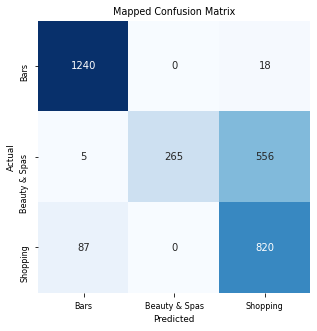

Precision : [0.93093093 1.         0.58823529]
Weighted precision: 0.846
Recall : [0.98569157 0.32082324 0.90407938]
Weighted recall: 0.846
Score : 0.159


In [15]:
from sklearn.cluster import AgglomerativeClustering

data_for_agglo = document_term_matrix.todense()
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

Here we get similar results as kmeans, thats because 'ward' clusters 
also uses SSE to determine when two clusters should be merged.

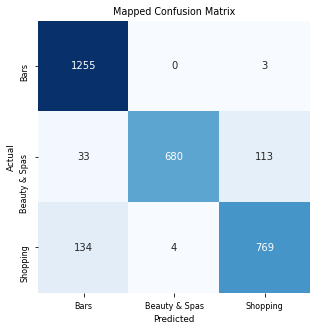

Precision : [0.88255977 0.99415205 0.86892655]
Weighted precision: 0.909
Recall : [0.99761526 0.82324455 0.84785006]
Weighted recall: 0.909
Score : 0.148


In [16]:
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='complete')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

'Complete' linkage will merge two clusters when all pairs of 
elements have been linked. Because of this strict criterion gives
this method an advantage on dense datasets. This is reflected on
our metrics results, we have only a small number of false labels
even though the silhouette coefficient is low.

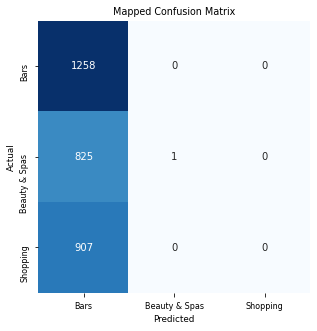

Precision : [0.42073579 1.         0.        ]
Weighted precision: 0.453
Recall : [1.         0.00121065 0.        ]
Weighted recall: 0.453
Score : 0.079


In [17]:
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='average')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

Group average manages to any classifiers. That is because 
this method is biased towards globular which is not true in our case.

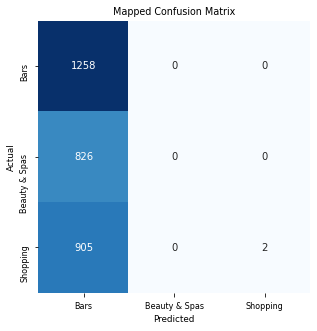

Precision : [0.42087655 0.         1.        ]
Weighted precision: 0.480
Recall : [1.         0.         0.00220507]
Weighted recall: 0.480
Score : 0.061


In [18]:
agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='single')
predictions = agglomerative.fit_predict(data_for_agglo)
display_agglomerative_info(true_labels, predictions, data_for_agglo)

Single method fails to find any of the classifiers as it merges all of our samples in a big cluster. Our dataset is dense and noisy both 
of which are limiting factors for this method.

## Part 2

### Running kmeans for a different number of cluster 

In [19]:
n_clusters = 12
max_score = 0
error = np.zeros(n_clusters+1)
score = np.zeros(n_clusters+1)
for k in range(2,n_clusters+1):     
    start = time.time()
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=25, max_iter=600,  random_state=42)
    preds = kmeans.fit_predict(document_term_matrix)
    error[k] = kmeans.inertia_
    score[k] = silhouette_score(document_term_matrix, preds)
    if (score[k] > max_score):
        f_clasters = k 
        max_score = score[k]
    stop = time.time()
    #print('Clusters {} finished, time {:.2f}s, score {:.2f}'.format(k, stop-start, score[k]))

### Silhouette plot

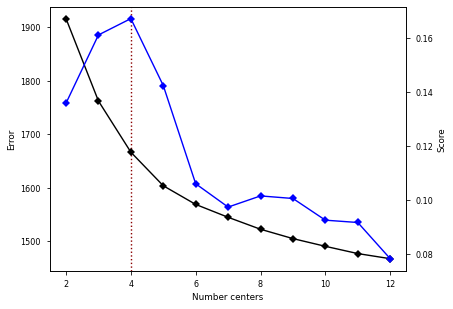

Best number of clusters 4, with silouhette coefficient of 0.1670.


In [20]:
# Displaying results
fig, ax1 = plt.subplots()
#plt.figure(figsize=(20, 6))
ax1.axvline(x=f_clasters, color='darkred', linestyle=':')
ax1.plot(np.array(range(2,n_clusters+1)), error[2:], marker='D', color='k')
ax1.set_xlabel('Number centers')
ax1.set_ylabel('Error')

ax2 = ax1.twinx()
ax2.plot(np.array(range(2,n_clusters+1)), score[2:], marker='D', color='b')
ax2.set_ylabel('Score')
fig.tight_layout()
plt.show()

print('Best number of clusters {}, with silouhette coefficient of {:.4f}.'.format(f_clasters, max_score))

We chose a number of cluster where kmeans has high silhouette 
coefficient score and low SSE.

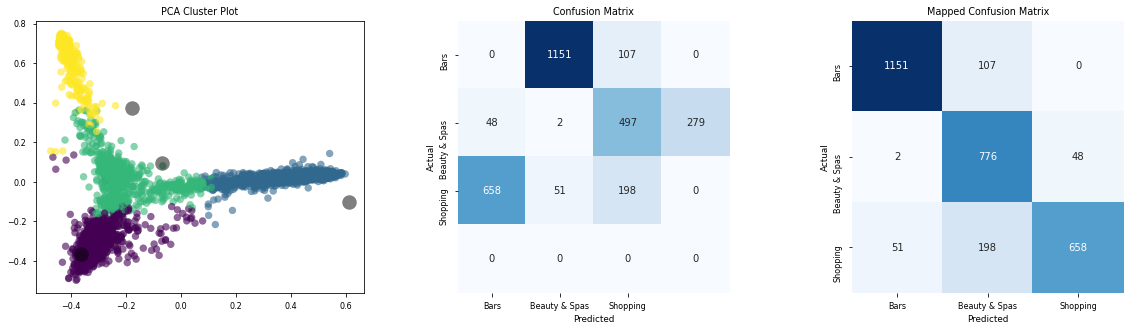

Precision : [0.95598007 0.71785384 0.93201133]
Weighted precision: 0.883
Recall : [0.91494436 0.93946731 0.72546858]
Weighted recall: 0.883
Score : 0.148


In [21]:
labels_c4, pred_c4, centers_2d_c4 = Kmeans_winfo(f_clasters, true_labels, document_term_matrix)

The results are improved, recall per cluster has better values than 
before and most of the misplaced buisnesses were placed in the correct
category.
In the cluster plot we can see that the 4th center is placed close to 
a dense part of the plot, this fixes part of the problem we had earlier. We can see that we now have more false values in the mapped 
confusion matrix at the second classifier. Since the new cluster is 
close to values that were previously part of other clusters some of those values are merged into the second category after the mapping.

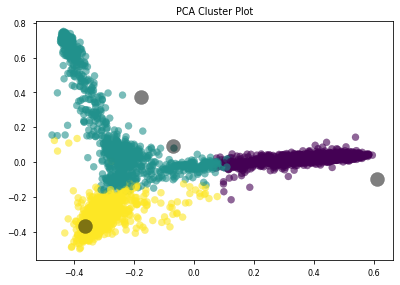

In [22]:
reduced_data = PCA(n_components=2).fit_transform(document_term_matrix.todense())

plt.title('PCA Cluster Plot')
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=labels_c4 ,s=50, cmap='viridis', alpha= 0.6)
plt.scatter(centers_2d_c4[:,0], centers_2d_c4[:,1], 
            marker='o', s=200, c='black', alpha=0.5)
plt.show()

In this plot we can see the three final categories. The new centroid 
was merged with the top centroid and took some of the values that were 
close to it.

### Display top 10 words for each classifier

In [23]:
disp_cluster_values(document_term_matrix, labels_c4)

food          0.356369
menu          0.139570
beer          0.121578
drinks        0.120938
ordered       0.114644
restaurant    0.112595
chicken       0.107310
night         0.101260
patio         0.090299
fries         0.085450
Name: 0, dtype: float64

hair           0.212220
appointment    0.121820
cut            0.088959
job            0.068636
clean          0.064628
work           0.058501
told           0.056930
recommend      0.054383
amazing        0.050814
skin           0.050356
Name: 1, dtype: float64

store        0.379579
shop         0.114798
stores       0.098609
buy          0.095114
selection    0.094057
items        0.088530
customer     0.082621
location     0.076244
products     0.071455
shopping     0.069394
Name: 2, dtype: float64